In [1]:
import sys; sys.path.insert(0, '../../external/')

%run ../initlibs.py cryptomomentum dark
from models.research_utils import load_data
from sklearn.base import TransformerMixin
from sklearn.pipeline import make_pipeline


import ira
%alphalab

from alpha.utils.data_helpers import FriendlyFxLoader

from qlearn.tracking.trackers import Tracker, TakeStopTracker, TurtleTracker, DispatchTracker, PipelineTracker, TimeExpirationTracker
from qlearn.core.base import BasicMarketEstimator, MarketDataComposer
from qlearn.core.pickers import SingleInstrumentPicker

from models.Q_models import *
from models.market_regime import MarketRegime, ADXRegime, AcorrRegime, VolatilityRegime

Reloaded ../../external/ira/experimental/c_simulator_core.pyx


In [2]:
timeframe = '5Min'
t_shift = pd.Timedelta(timeframe) - pd.Timedelta('1s')

data = ohlc_resample(load_data('BTCUSDT'), timeframe)

We will use new framework (QLearn) for development this model as it should give us more flexible approach to 
testing mixed models.
<hr/>

In [3]:
b_ents = MarketDataComposer(
    make_pipeline(RollingRange('1d', 55), RangeBreakoutDetector()), 
    SingleInstrumentPicker(), None)

b_exits = MarketDataComposer(
    make_pipeline(RollingRange('1d', 10), RangeBreakoutDetector()), 
    SingleInstrumentPicker(), None)

s = shift_signals(
    srows(
        1 * b_ents.fit(data, None).predict(data),
        2 * b_exits.fit(data, None).predict(data),
        pd.DataFrame({'BTCUSDT': 'regime:m1'}, index=pd.DatetimeIndex(['2017-10-14 15:00:00']))
    ), t_shift)

In [4]:
tracker = TurtleTracker(3000, None, max_units=4, risk_capital_pct=0.03, max_allowed_contracts=1000, pull_stops_on_incr=True, after_lose_only=False, debug=True)
p = z_backtest(s, data, 'crypto_futures', spread=0.5, execution_logger=True, trackers=tracker)

	[2017-10-12 08:04:59] -> [#1] BTCUSDT 14 @ 5110.54 x 4454.49
	[2017-10-12 15:39:00] -> [#2] BTCUSDT <5192.89> increasing to 28 @ 5275.25 x 4536.84
	[2017-10-13 00:04:00] -> [#3] BTCUSDT <5280.47> increasing to 42 @ 5455.61 x 4594.24
	[2017-10-13 02:24:00] -> [#4] BTCUSDT <5375.14> increasing to 57 @ 5640.23 x 4688.91
[2017-11-11 13:29:59] -> Close in profit BTCUSDT @ 6201.75
	[2017-11-16 19:04:59] -> [#1] BTCUSDT 13 @ 7750.34 x 6687.42
	[2017-11-19 18:04:00] -> [#2] BTCUSDT <7888.80> increasing to 26 @ 8027.27 x 6808.60
	[2017-11-20 23:19:00] -> [#3] BTCUSDT <8032.13> increasing to 40 @ 8298.3 x 6958.65
	[2017-11-25 16:49:00] -> [#4] BTCUSDT <8174.79> increasing to 55 @ 8555.22 x 7165.49
[2017-12-21 15:39:59] -> Close in profit BTCUSDT @ 15099.75
	[2018-02-01 19:24:59] -> [#1] BTCUSDT -5 @ 9056.12 x 12269.03
	[2018-02-02 11:44:00] -> [#2] BTCUSDT <-8653.46> increasing to -10 @ 8250.79 x -5442.79
 -> [2018-02-02 11:44:00] stop short [BTCUSDT] at 8250.79000
	[2018-02-02 14:29:59] -> [#1

Statistic,Model
Gain (USD):,318.39
CAGR (%):,2.090
Sharpe:,1.313
Sortino:,2.294
Calmar:,1.680
MaxDD (%):,1.585
MaxDD On Init BP (%):,1.698
MaxDD (USD):,50.952
MaxDD days:,525 days
MaxDD start:,2019-05-30

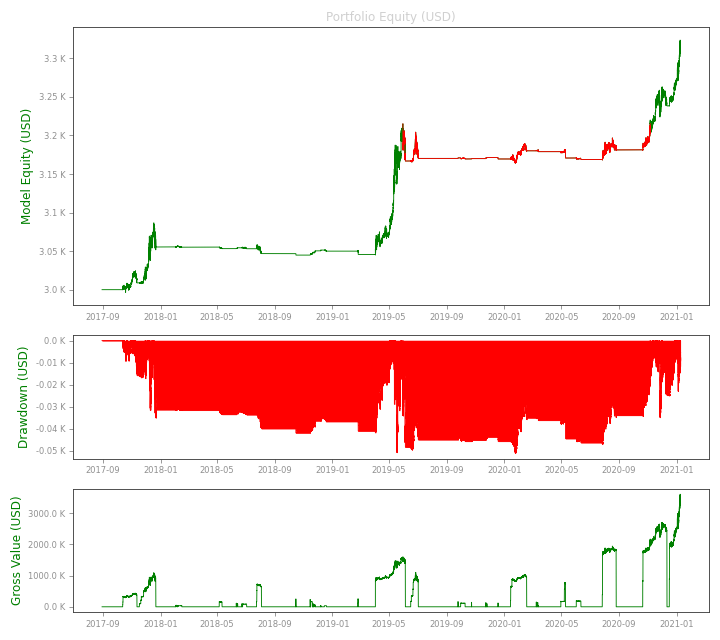

<Figure size 720x640 with 0 Axes>

In [5]:
tearsheet(p, tracker.account_size)

In [6]:
p.executions.tail()

,instrument,quantity,exec_price,comment
2020-12-11 11:39:59,BTCUSDT,-136,17609.74,
2020-12-16 13:49:59,BTCUSDT,21,20245.88,
2020-12-16 14:14:00,BTCUSDT,22,20798.60,increased position to 43 at 20798.6
2020-12-16 21:54:00,BTCUSDT,22,21267.01,increased position to 65 at 21267.01
2020-12-17 01:14:00,BTCUSDT,21,21767.82,increased position to 86 at 21767.82


# On hourly timeframe breakouts

In [9]:
b_e1h = MarketDataComposer(
    make_pipeline(RollingRange('1h', 10), RangeBreakoutDetector()), 
    SingleInstrumentPicker(), None).fit(data, None).predict(data)

b_x1h = MarketDataComposer(
    make_pipeline(RollingRange('1h', 6), RangeBreakoutDetector()), 
    SingleInstrumentPicker(), None).fit(data, None).predict(data)

s1h = shift_signals(srows(1 * b_e1h, 2 * b_x1h), '4M59Sec')

In [ ]:
p1h_s1 = z_backtest(s1h, data, 'crypto_futures', spread=0.5, execution_logger=True, 
                 trackers=TurtleTracker(
                     3000, None, max_units=4, risk_capital_pct=0.05, 
                     atr_timeframe='1h',
                     after_lose_only=True,
                     max_allowed_contracts=1000, pull_stops_on_incr=True, debug=False)
                )

p1h_s2 = z_backtest(s1h, data, 'crypto_futures', spread=0.5, execution_logger=True, 
                 trackers=TurtleTracker(
                     3000, None, max_units=4, risk_capital_pct=0.05, 
                     atr_timeframe='1h',
                     after_lose_only=False,
                     max_allowed_contracts=1000, pull_stops_on_incr=True, debug=False)
                )

Statistic,Model
Gain (USD):,1952.88
CAGR (%):,10.681
Sharpe:,1.429
Sortino:,4.444
Calmar:,1.752
MaxDD (%):,7.054
MaxDD On Init BP (%):,8.036
MaxDD (USD):,241.078
MaxDD days:,141 days
MaxDD start:,2018-10-15

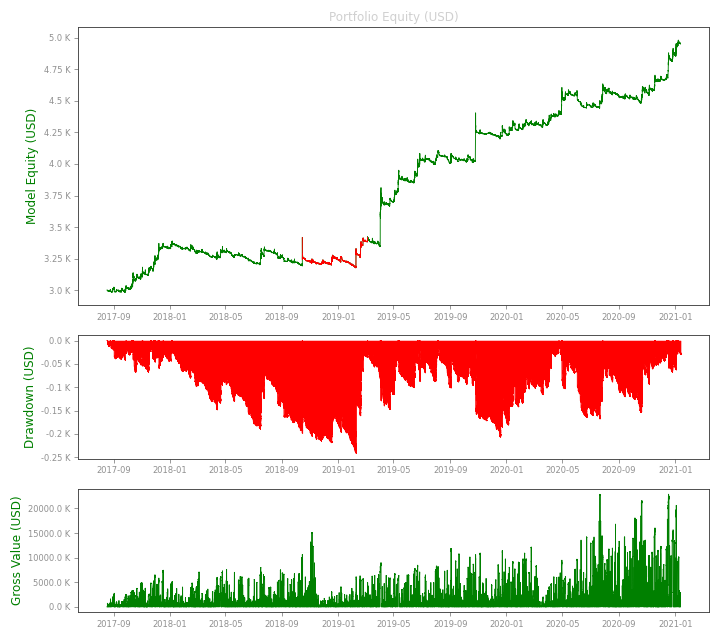
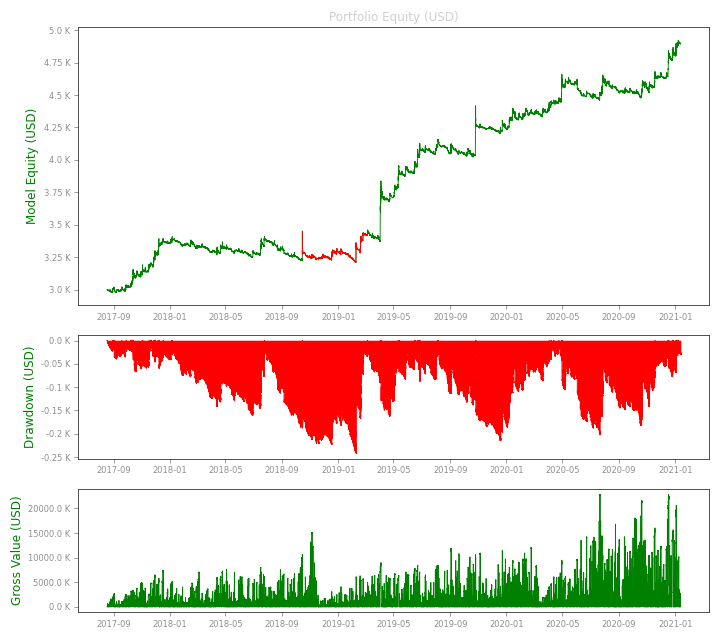

<Figure size 720x640 with 0 Axes>

<Figure size 720x640 with 0 Axes>

In [200]:
tearsheets(p1h_s1, p1h_s2,  init_cash=3000)

# Pivots generators

In [3]:
p_sigs_d = generate_pivots_signals(PivotsRange('D'), data, t_shift)
p_sigs_w = generate_pivots_signals(PivotsRange('W', 'camarilla'), data, t_shift)

In [4]:
pvt_d_s1 = z_backtest(p_sigs_d, data, 'crypto_futures', spread=0.5, execution_logger=True, 
                    trackers=TurtleTracker(
                        3000, None, max_units=4, risk_capital_pct=0.05, 
                        atr_timeframe='1h',
                        after_lose_only=True,
                        max_allowed_contracts=1000, pull_stops_on_incr=True, debug=False)
                    )
pvt_w_s1 = z_backtest(p_sigs_w, data, 'crypto_futures', spread=0.5, execution_logger=True, 
                    trackers=TurtleTracker(
                        3000, None, max_units=4, risk_capital_pct=0.05, 
                        atr_timeframe='1h',
                        after_lose_only=True,
                        max_allowed_contracts=1000, pull_stops_on_incr=True, debug=False)
                    )

Statistic,Model
Gain (USD):,2408.97
CAGR (%):,12.683
Sharpe:,1.776
Sortino:,5.225
Calmar:,3.656
MaxDD (%):,5.856
MaxDD On Init BP (%):,7.056
MaxDD (USD):,211.678
MaxDD days:,131 days
MaxDD start:,2018-10-15

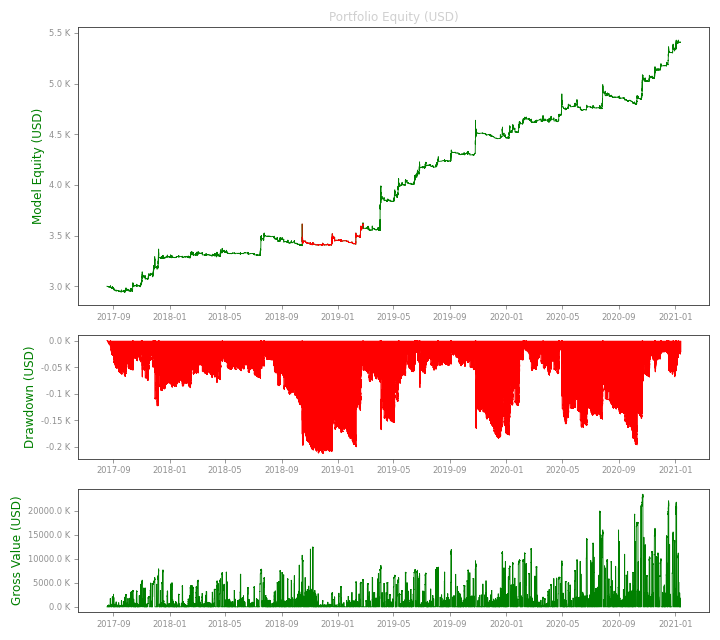

<Figure size 720x640 with 0 Axes>

In [5]:
tearsheet(pvt_d_s1, 3000)

Statistic,Model
Gain (USD):,2392.69
CAGR (%):,12.646
Sharpe:,1.446
Sortino:,2.948
Calmar:,2.138
MaxDD (%):,7.113
MaxDD On Init BP (%):,12.357
MaxDD (USD):,370.712
MaxDD days:,137 days
MaxDD start:,2020-08-02

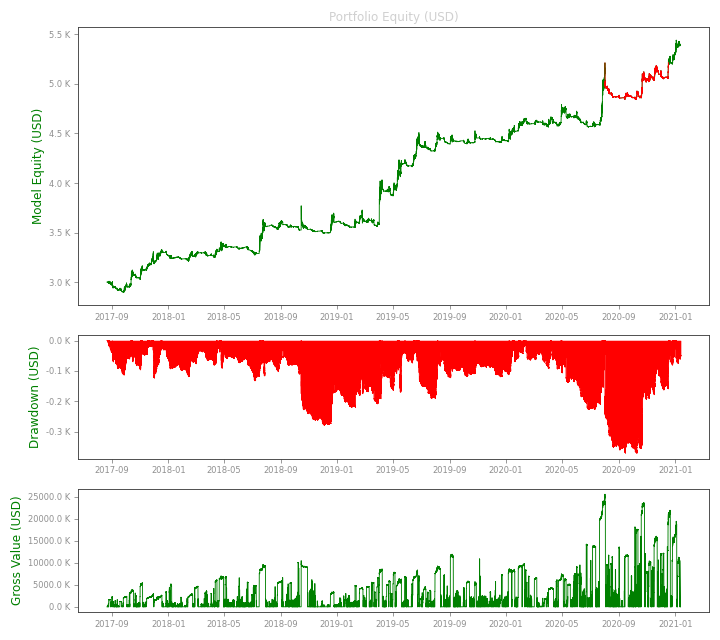

<Figure size 720x640 with 0 Axes>

In [6]:
tearsheet(pvt_w_s1, 3000)

### <font color='green'>Best model from previous studies: Daily/Pivots(Camarilla) </font>

In [38]:
pvt_w_s1 = z_backtest(generate_pivots_signals(PivotsRange('D', 'camarilla'), data, t_shift), 
                      data, 'crypto_futures', spread=0.5, execution_logger=True, 
                      trackers=TurtleTracker(
                          3000, None, max_units=4, risk_capital_pct=0.05, 
                          atr_timeframe='1h',
                          after_lose_only=True,
                          max_allowed_contracts=1000, pull_stops_on_incr=True, debug=False)
                      )

Statistic,Model
Gain (USD):,2387.24
CAGR (%):,12.591
Sharpe:,1.531
Sortino:,4.599
Calmar:,2.841
MaxDD (%):,8.809
MaxDD On Init BP (%):,10.092
MaxDD (USD):,302.746
MaxDD days:,168 days
MaxDD start:,2018-10-15

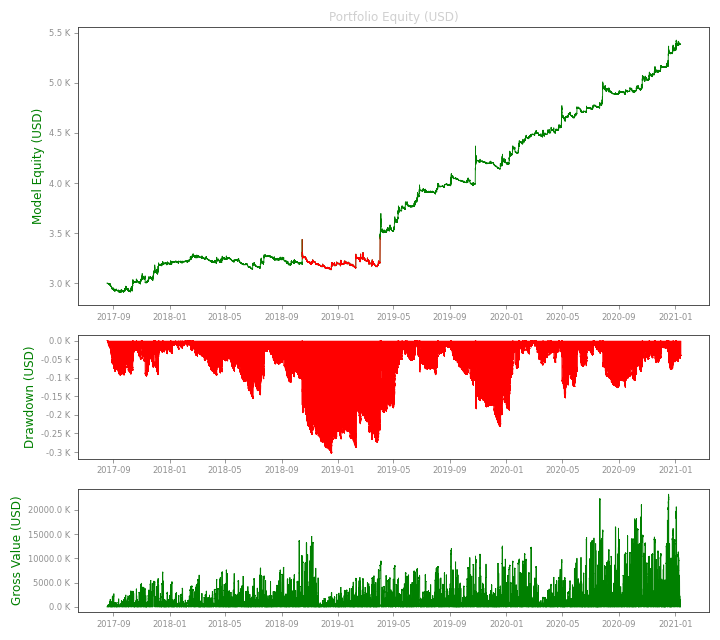

<Figure size 720x640 with 0 Axes>

In [40]:
tearsheet(pvt_w_s1, 3000)

# <font color='red'>Regime switching</font>

In [31]:
class SignalsCutter(Tracker):
    def on_signal(self, signal_time, signal_qty, quote_time, bid, ask, bid_size, ask_size):
        return np.nan # if abs(signal_qty)==1 else signal_qty

In [32]:
# m2 = AcorrRegime(period=3*12, lag=1, t_mr=-0.01, t_mo=0.01).fit(data['BTCUSDT'])
m2 = ADXRegime(period=36, threshold=25).fit(data['BTCUSDT'])
r1 = m2.regime()
r1 = r1.replace({1: 'trend', 0: 'mr'}).rename('BTCUSDT').dropna().to_frame().astype(str)
# r1 = r1.replace({1: 'trend', 0: np.nan, -1: 'mr'}).rename('BTCUSDT').dropna().to_frame().astype(str)

In [28]:
signals = generate_pivots_signals(PivotsRange('D', 'camarilla'), data, t_shift)

Now we'll try to filter out all entries if it's not 'trend' regime on the market
We will use capital \$3000 and risk 5\% per entry

In [33]:
btracker = TurtleTracker(
    3000, None, max_units=4, risk_capital_pct=0.05, 
    atr_timeframe='1h', after_lose_only=True, max_allowed_contracts=1000, pull_stops_on_incr=True, debug=False)

p_reg = z_backtest(
    srows(signals, r1), data, 'crypto_futures', spread=0.5, execution_logger=True, 
    trackers=DispatchTracker({
        
        'trend': btracker,
        
        'mr': PipelineTracker(SignalsCutter(), btracker)
        
    }, active_tracker=None, flat_position_on_activate=False, debug=False)
)

Statistic,Model
Gain (USD):,2087.05
CAGR (%):,11.281
Sharpe:,1.804
Sortino:,4.591
Calmar:,3.382
MaxDD (%):,6.840
MaxDD On Init BP (%):,8.931
MaxDD (USD):,267.941
MaxDD days:,170 days
MaxDD start:,2018-10-15

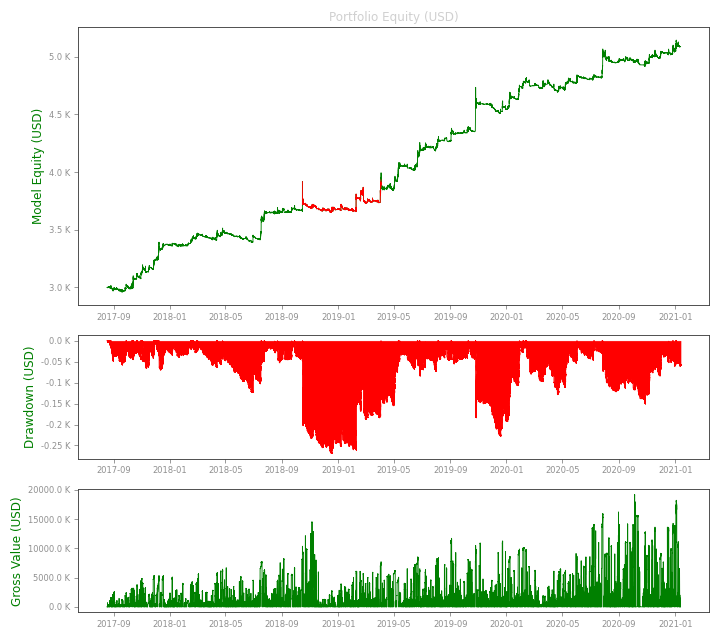

<Figure size 720x640 with 0 Axes>

In [34]:
tearsheet(p_reg, 3000)

### Comparison of PnL curves for best model without market regime and with it

Statistic,Model
Gain (USD):,2387.24
CAGR (%):,12.591
Sharpe:,1.531
Sortino:,4.599
Calmar:,2.841
MaxDD (%):,8.809
MaxDD On Init BP (%):,10.092
MaxDD (USD):,302.746
MaxDD days:,168 days
MaxDD start:,2018-10-15

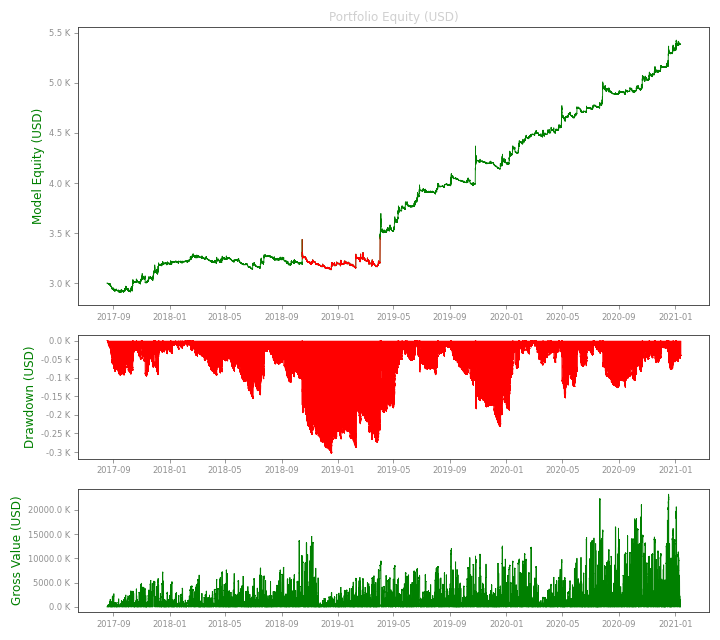
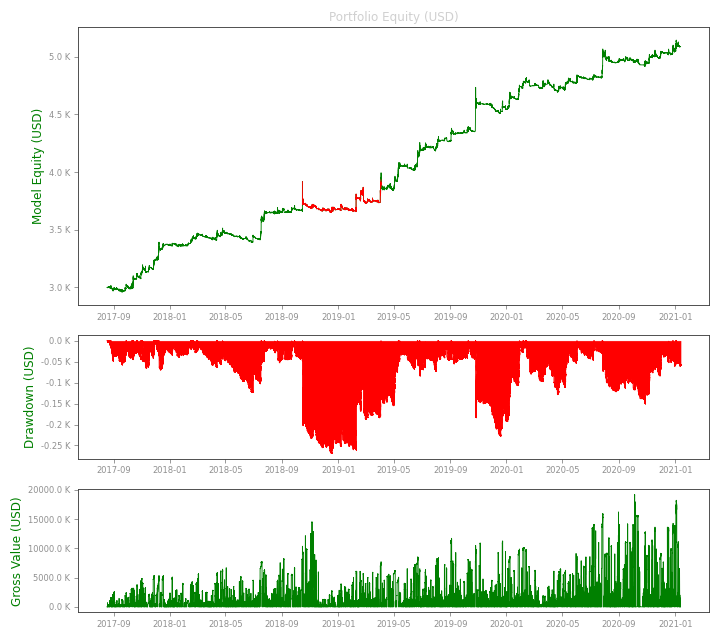

<Figure size 720x640 with 0 Axes>

<Figure size 720x640 with 0 Axes>

In [41]:
tearsheets(pvt_w_s1, p_reg, init_cash=3000)

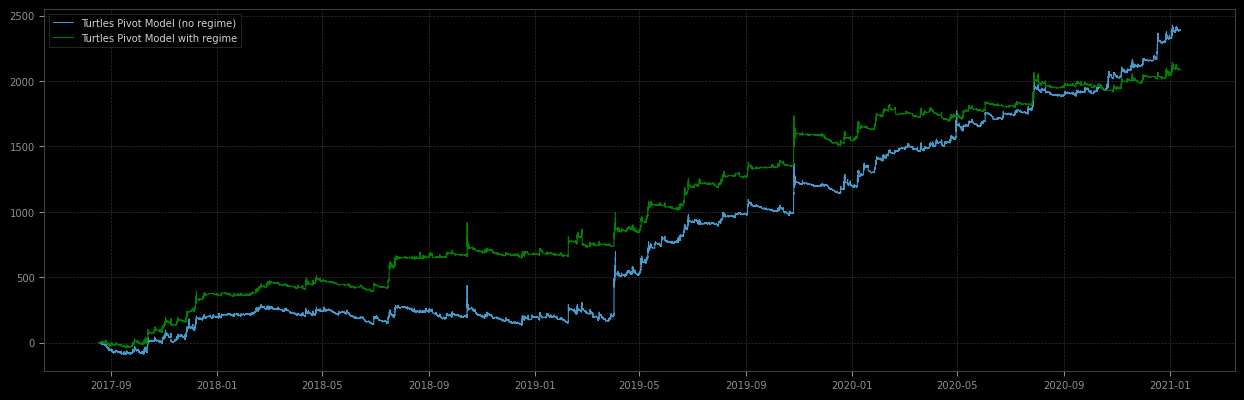

In [48]:
fig(16, 5)
plt.plot(pvt_w_s1.portfolio.filter(regex='.*_PnL').cumsum(), label='Turtles Pivot Model (no regime)')
plt.plot(p_reg.portfolio.filter(regex='.*_PnL').cumsum(), label='Turtles Pivot Model with regime');
plt.legend();

As we can see introducing regime led to more smooth PnL curve.